# Part 1: Native Language Identification (Multi-class)

The goal is to train a neural network on the Cambridge FCE dataset to predict the native language of the author of some text. This will be a classification task: the six languages/countries we focus on are Chinese (China), French (France), German (Germany), Greek (Greece), Portuguese (Portugal), and Spanish (Spain).

We mainly compare two methods: neural network and logistic regression.

For the neural network, instead of feeding in the raw documents directly into the neural network, we want to use BERT embeddings as the input.

We will compare the neural network's performance with a "simpler" model: logistic regression, with various different combinations of input features and parameters.

More information about the dataset can be found in the GitHub repo.

**Acknowledgement: Much of the base code is from LIN 371 lecture demos, Fall 2024, Jessy Li & Hongli Zhan.**

## Libraries, Data, and connecting to GPU

In [166]:
#from google.colab import drive
#drive.mount('/content/drive')

In [167]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [168]:
### Import relevant libraries

import numpy as np
import pandas as pd
import random
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# BERT
from transformers import BertTokenizer, BertModel

# sklearn
from sklearn.metrics import f1_score
from sklearn.datasets import load_files
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Previously, we made a one-hot encoded version of the data where our desired outcome variable (native language) was transformed into a one-hot vector. The one-hot encoding is necessary for multi-class classification. (https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/)

In [169]:
# Load data

#data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LIN 371/Project/fce_6languages.csv")
data = pd.read_csv("data/fce_6languages.csv")
data = data.dropna()

### For testing only to ensure model works before running on larger dataset
# data = data.sample(frac=0.1)

In [170]:
# Take a look at the FCE dataset

print(data.shape)
data.head()

(1228, 90)


,filename,native_language,Chinese,French,German,Greek,Portuguese,Spanish,age,total_score,...,UJ,UN,UP,UQ,UT,UV,UY,W,X,unknown
0,0100_2000_6/doc2.xml,Chinese,True,False,False,False,False,False,16-20,24.0,...,0,0,0,0,1,0,0,0,0,0
1,0100_2000_6/doc2.xml,Chinese,True,False,False,False,False,False,16-20,24.0,...,0,0,0,1,0,1,0,0,0,0
2,0100_2000_6/doc4.xml,Chinese,True,False,False,False,False,False,21-25,17.0,...,0,2,1,0,3,2,0,1,0,0
3,0100_2000_6/doc4.xml,Chinese,True,False,False,False,False,False,21-25,17.0,...,0,0,5,0,3,1,0,0,0,0
4,0100_2000_6/doc24.xml,Spanish,False,False,False,False,False,True,16-20,32.0,...,0,0,0,0,0,0,1,0,0,0


There are 1228 rows and 90 columns. Each row represents a unique example in the dataset, where the writer's native language was one of Chinese, French, German, Greek, Portuguese, or Spanish.

The relevant columns are `answer` (the text output by the author), the columns from `Chinese` to `Spanish`, which is the one-hot encoding of the `native_language` column, and the `native_language` column itself.

The rest of the columns are other features of the authors like their age, score on the exam, and frequency of mistakes made, which we will not be looking at in this part.

In [171]:
# Helper dictionary to decode index to label

decode_l1 = {0:"Chinese", 1:"French", 2:"German", 3:"Greek", 4:"Portuguese", 5:"Spanish"}
encode_l1 = {v: k for k, v in decode_l1.items()}
lang_list = ["Chinese", "French", "German", "Greek", "Portuguese", "Spanish"]

Because the task is complex, we need to connect to one of the GPUs offered (for free) by Google Colab, which has better parallel computing capabilities.

In [172]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Dataset processing

We'll first create training, testing, and validation sets. Here is a nice function written by Anjie to help.

One thing to note: the target will be a matrix with 5 columns (for the 6 native languages we are trying to classify to), instead of 1 column (which corresponds with the binary classification tasks that we have been demo-ing in class).

In [173]:
def train_test_split_by_students(df, train_size=0.8, test_size=0.1, val_size=0.1):
    # By default, we set aside 80% of data for training, 10% for testing, and 10% for validation
    assert train_size + test_size + val_size == 1

    # Split students
    students = np.unique(df['filename'])
    students_train, students_temp = train_test_split(students, test_size=(test_size + val_size), random_state=1000)
    students_test, students_val = train_test_split(students_temp, test_size=(val_size / (test_size + val_size)), random_state=1000)
    print(f"Number of Students in Train: {students_train.size}, Test: {students_test.size}, Validation: {students_val.size}")

    # Split the data by students
    train = df[df['filename'].isin(students_train)]
    test = df[df['filename'].isin(students_test)]
    val = df[df['filename'].isin(students_val)]

    # Input feature and Output
    feature = ['answer']
    X_train, X_test, X_val = train[feature], test[feature], val[feature]
    y_train, y_test, y_val = train.loc[:,"Chinese":"Spanish"], test.loc[:,"Chinese":"Spanish"], val.loc[:,"Chinese":"Spanish"]

    print(f"Training Size: {len(X_train)}, Test Size: {len(X_test)}, Validation Size: {len(X_val)}")

    return X_train, X_test, X_val, y_train, y_test, y_val

In [174]:
# Call train_test_split_by_students() to create our training, testing, and validation sets

X_train, X_test, X_val, y_train, y_test, y_val = train_test_split_by_students(df = data, train_size=0.8, test_size=0.1, val_size=0.1)

Number of Students in Train: 493, Test: 62, Validation: 62
Training Size: 980, Test Size: 124, Validation Size: 124


In [175]:
# Sanity check: Take a look at X_train and y_train

print(X_train.head())
print(y_train.head())

                                              answer
0  Dear Mr Ryan.\nThanks for you letter. I am so ...
1  As our class is going to mark a short video ab...
2  Dear Madam Helen Ryan,\nI have received your l...
3  I agree! Sometimes shopping is not always enjo...
4  Dear Mrs. Ryan,\nFirst of all, I would like to...
   Chinese  French  German  Greek  Portuguese  Spanish
0     True   False   False  False       False    False
1     True   False   False  False       False    False
2     True   False   False  False       False    False
3     True   False   False  False       False    False
4    False   False   False  False       False     True


## 0) A random baseline

Here are some different random baselines we can combine the model performance to.

### Random guessing

For random guessing, the theoretical accuracy can be calculated as the sum across all categories of P(guessing class _i_) * P(example is that class _i_). Both of those probabilities will be the proportion of class _i_ present in the dataset.

In [176]:
# Random guessing accuracy (analytical)

((data["native_language"].value_counts() / len(data))**2).sum()

np.float64(0.20812024530764253)

If classes were balanced and each had equal probability of being chosen as the predicted class, then the theoretical accuracy is 1/6.

In [177]:
1/6

0.16666666666666666

### Zero Rate Classifier

If every example is predicted as the class that has a majority, what is the accuracy? (note: we really mean a plurality here since no class has an absolute majority)

In [178]:
lang_counts = data["native_language"].value_counts()
lang_counts = lang_counts.reindex(lang_list)
lang_counts = lang_counts.to_frame().reset_index()
lang_counts

,native_language,count
0,Chinese,131
1,French,288
2,German,133
3,Greek,144
4,Portuguese,136
5,Spanish,396


In our dataset (includes all training, testing, and validation examples), Spanish has the most amount of examples at 396.

In [179]:
data["native_language"].value_counts().max() / len(data)

np.float64(0.32247557003257327)

A random baseline accuracy using a zero rate classifier is **0.322**, if everything were predicted as Spanish. If our model can do better than this, then it will be very good.

### Random simulation macro F1

Compute a baseline for macro-F1 score based on random simulation.

In [180]:
# Function to generate a baseline for macro F1 based on random sampling

def random_simulate_macrof1(data = data, lang_counts = lang_counts, n=100):

    sample_f1 = [None] * n
    actual = data["native_language"].to_list()

    # Generate random guesses for native language, weighted by proportion of each class in existing data
    for i in range(n):
        random_sampled_l1 = lang_counts.sample(n=len(data), weights = "count", replace = True)
        random_sampled_l1 = random_sampled_l1["native_language"].to_list()

        sample_f1[i] = f1_score(random_sampled_l1, actual, average = "macro")

    return np.mean(sample_f1)



In [181]:
random_simulate_macrof1()


np.float64(0.16566771151643322)

This macro-f1 average from the random simulation is about 0.167.

## 1) Neural network model with BERT embeddings

We'll use DataLoader to do batching, which is necessary for something complicated like BERT. This helps process examples in parallel, and it's more efficient than running each example one by one.

Recall for our project: we have the data in a .csv file, and the input (text) is in a column called `answer`, while the output label (native language) is in a column called `native_language`.

In [182]:
# Use BERT's tokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The max length of BERT tokens is 512, but this takes up too much RAM, so we need to decrease the max length...

In [183]:
### Prepare data for DataLoader with a custom Dataset class

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    # self.texts and self.labels are both lists of vectors
    self.texts = [bert_tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                            return_tensors="pt") for text in X.squeeze()]
    self.labels = y.to_numpy().tolist()

  def __len__(self):
    return len(self.labels)

  def get_batch_labels(self, idx):
    # Fetch a batch of labels
    return np.array(self.labels[idx])

  def get_batch_texts(self, idx):
    # Fetch a batch of inputs
    return self.texts[idx]

  def __getitem__(self, idx):
    batch_texts = self.get_batch_texts(idx)
    batch_y = self.get_batch_labels(idx)
    return batch_texts, batch_y

In [184]:
# Create Datasets for training, testing, and validation

train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
val_dataset = Dataset(X_val, y_val)

In [185]:
# Sanity check

print("Length of training dataset:", len(train_dataset))
print("Length of testing dataset:", len(test_dataset))
print("Length of validation dataset:", len(val_dataset))

print(train_dataset.get_batch_texts(90))
print(train_dataset.get_batch_labels(90))

Length of training dataset: 980
Length of testing dataset: 124
Length of validation dataset: 124
{'input_ids': tensor([[  101,  9810,  1010,  6122,  2238,  2456,  6203,  3680,  4575,  4067,
          2017,  1037,  2843,  2005,  2115,  2785,  3661,  1012,  1045,  2001,
          2200,  4527,  2006,  1996,  2765,  1997,  1996,  2971,  1012,  2085,
          1045,  2572,  3407,  2000,  2507,  2017,  2035,  1996,  2592,  2017,
          2342,  1012,  1045,  2228,  2009,  2052,  2022,  2488,  2005,  2033,
          2000,  3604,  2006,  2251,  1012,  1045,  2097,  2318,  2019,  3059,
          2607,  1999,  2257,  1010,  2061,  2009,  2097,  2022,  5263,  2005,
          2033,  2000,  2681,  1012,  1999,  2115,  3661,  2017,  3198,  2033,
          2000,  5454, 10506,  2102, 28394,  2078, 17732,  2030,  8833, 20321,
          1010,  2092,  1045,  9544,  2000,  2994,  1999,  1037,  8833,  6644,
          1012,  2009,  2003,  2062,  9530, 13028,  3085,  1998,  1045,  2572,
          4452,  205

Now we'll prepare the data for training with DataLoader (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which will allow us to iterate through the data in batches. After some testing, it seems like Cuda runs out of RAM if the batch size is too large, because there are too many computations being done at once. So, we are sticking with a batch size of 8.

In [186]:
# Specify a batch size for training

batch_size = 8

# Convert Dataset to DataLoader with specified batch size and shuffling

def dataset_to_loader(dataset):
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)

# Make instance of DataLoader for each of train, test, and val

train_loader = dataset_to_loader(train_dataset)
test_loader = dataset_to_loader(test_dataset)
val_loader = dataset_to_loader(val_dataset)

In [187]:
# Sanity check: Length of each DataLoader (i.e. the number of batches)

print("Length of training dataloader:", len(train_loader))
print("Length of testing dataloader:", len(test_loader))
print("Length of validation dataloader:", len(val_loader))

Length of training dataloader: 123
Length of testing dataloader: 16
Length of validation dataloader: 16


We will customize models from already available base model classes. The `nn.Module` base class from Pytorch is the neural network base class, but we need to add a layer for being able to use BERT embeddings for the CLS token as the model's input.

The number of dimensions in the base BERT model is **768**, which will be the input dimension for the first layer.

The number of language classes we have is **6**, which will be the output dimension of the output layer, which will contain each class's respective weights. We'll use the Softmax activation function (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html, https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html).

#### BERT model base class

In [188]:
### Feedforward neural network class that takes in BERT embeddings as inputs

class feedforward_nn_bert(nn.Module):

  def __init__(self, dropout = 0.1, freeze_layer_count = 6):
    super().__init__()

    # Initialize a BERT model as an attribute to help get embeddings
    self.bert = BertModel.from_pretrained('bert-base-uncased')

    # Freeze BERT layers
    if freeze_layer_count:
            # We freeze here the embeddings of the model
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False

            if freeze_layer_count != -1:
                # if freeze_layer_count == -1, we only freeze the embedding layer
                # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in self.bert.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False

    # Regularization technique: dropout
    if dropout:
      self.dropout = nn.Dropout(dropout)
    else:
      self.dropout = None

    ### Layers to the neural network
    self.fc1 = nn.Linear(768, 10)   # First hidden layer requires input dim = 768
    self.fc2 = nn.Linear(10, 6)     # Output layer requires output dim = 6


  def forward(self, input_id, mask):

    # First step in the forward pass: get text-level embeddings of the CLS token
    _, CLS = self.bert(input_ids = input_id, attention_mask = mask, return_dict = False)

    # Regularization technique: dropout
    if self.dropout:
      x = self.dropout(CLS)

    ### Layers to the neural network
    x = f.relu(self.fc1(CLS))   # Hidden layer
    x = f.softmax(self.fc2(x))  # Output layer: multi-class classification

    return x

Now we can create the neural network as an instance of the `feedforward_nn_bert` class.

In [189]:
X_train.shape

(980, 1)

In [190]:
# Create our neural network as an instance of the feedforward_nn_bert class

model = feedforward_nn_bert()

### BERT model training

In [191]:
# Define number of epochs (training iterations) and optimizer (loss function)

epochs = 5

### CrossEntropyLoss loss function for multiclass classification

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [192]:
### Train the model on our training set

def train_nn(model,
             train_loader, val_loader,
             use_cuda,
             learning_rate = 2e-2, epochs = epochs, batch_size = batch_size):

  if use_cuda:
    model = model.cuda()

  for epoch in range(epochs):

    # In training set
    for inputs, labels in tqdm(train_loader, leave = False):
      train_labels = labels.type(torch.LongTensor).to(device)
      input_ids = inputs['input_ids'].squeeze(1).to(device)
      attention_masks = inputs['attention_mask'].to(device)

      model.train()
      output = model(input_ids, attention_masks)
      #output = torch.squeeze(output, dim=1)  # Squeeze the output tensor

      batch_loss = criterion(output, train_labels.float())

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()

    # Validation step
    model.eval()
    val_loss, val_accuracy, val_labels, val_preds, report = eval_nn(model, val_loader)
    scheduler.step()

    # Print as we train the loss and accruacy for each epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {batch_loss.item():.3f}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}')


  return model

In [193]:
### Evaluate model on validation set

def eval_nn(model, val_loader):

    model.eval()  # Set the model to evaluation mode

    # Record the actual labels and predicted labels
    val_labels, val_preds = [], []

    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        # In the dataset we are evaluating on
        for input, label in val_loader:

            val_label = label.float().argmax(dim=1).to(device)    # Actual class label
            input_ids = input['input_ids'].squeeze(1).to(device)
            attention_masks = input['attention_mask'].to(device)

            output = model(input_ids, attention_masks)
            output = output.float()

            # Compute loss & accuracy
            val_loss += criterion(output, val_label).item()   # For each batch, add loss to total

            predicted = output.argmax(dim = 1)   # Predicted class label
            total += label.size(0)
            correct += (predicted == val_label).sum().item()

            # Record the actual labels and predicted labels
            val_labels.extend(val_label.tolist())
            val_preds.extend(output.argmax(dim=1).tolist())

        val_loss /= len(val_loader)
        val_accuracy = correct / total

        report = classification_report(y_true = val_labels, y_pred = val_preds, zero_division=1)

    return val_loss, val_accuracy, val_labels, val_preds, report

### BERT model evaluation

We can finally call the functions that we made to make predictions. NOTE: This process takes several minutes...

Version with dropout regularization:

In [194]:
model = train_nn(model,
         train_loader, val_loader,
         use_cuda,
         learning_rate = 2e-2, epochs = epochs, batch_size = batch_size)

  0%|          | 0/123 [00:00<?, ?it/s]/var/folders/k4/0qlr7kps5m9fslp8sm9s9ds00000gn/T/ipykernel_92473/345369206.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))  # Output layer: multi-class classification


Epoch 1/5, Loss: 1.819, Val Loss: 1.792, Val Accuracy: 0.242


  0%|          | 0/123 [00:00<?, ?it/s]/var/folders/k4/0qlr7kps5m9fslp8sm9s9ds00000gn/T/ipykernel_92473/345369206.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))  # Output layer: multi-class classification


Epoch 2/5, Loss: 1.797, Val Loss: 1.790, Val Accuracy: 0.242


  0%|          | 0/123 [00:00<?, ?it/s]/var/folders/k4/0qlr7kps5m9fslp8sm9s9ds00000gn/T/ipykernel_92473/345369206.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))  # Output layer: multi-class classification


Epoch 3/5, Loss: 1.780, Val Loss: 1.786, Val Accuracy: 0.242


  0%|          | 0/123 [00:00<?, ?it/s]/var/folders/k4/0qlr7kps5m9fslp8sm9s9ds00000gn/T/ipykernel_92473/345369206.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))  # Output layer: multi-class classification


Epoch 4/5, Loss: 1.749, Val Loss: 1.785, Val Accuracy: 0.242


  0%|          | 0/123 [00:00<?, ?it/s]/var/folders/k4/0qlr7kps5m9fslp8sm9s9ds00000gn/T/ipykernel_92473/345369206.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))  # Output layer: multi-class classification


Epoch 5/5, Loss: 1.737, Val Loss: 1.785, Val Accuracy: 0.242


In [195]:
# Visualize confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def create_cm(actual_labels, predicted_labels):
    cm = confusion_matrix(actual_labels, predicted_labels)
    palette = sns.color_palette("Blues",as_cmap=True)
    s = sns.heatmap(cm, annot=True, cmap=palette, xticklabels=lang_list, yticklabels=lang_list)

    s.set(xlabel='Predicted Label', ylabel='True Label')

/var/folders/k4/0qlr7kps5m9fslp8sm9s9ds00000gn/T/ipykernel_92473/345369206.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))  # Output layer: multi-class classification


              precision    recall  f1-score   support

           0       1.00      0.00      0.00        18
           1       1.00      0.00      0.00        28
           2       1.00      0.00      0.00        16
           3       1.00      0.00      0.00        16
           4       1.00      0.00      0.00        14
           5       0.26      1.00      0.41        32

    accuracy                           0.26       124
   macro avg       0.88      0.17      0.07       124
weighted avg       0.81      0.26      0.11       124



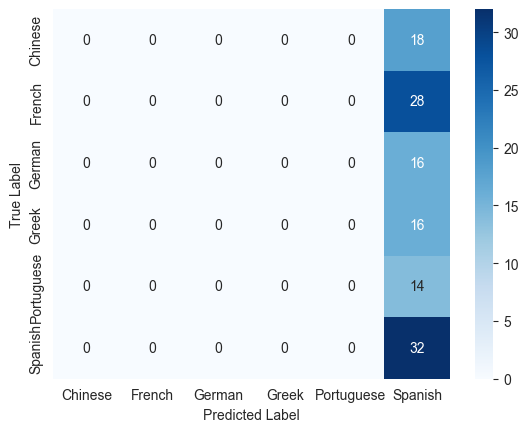

In [196]:
test_loss, test_accuracy, test_labels, test_preds, report = eval_nn(model, test_loader)

print(report)
create_cm(test_labels, test_preds)

Interesting... all examples are being predicted as French

### Testing on Reddit L2 corpus

The Reddit L2 corpus contains comments from Reddit users, labelled with their country of origin. We'll test the neural network model on this dataset to see if the model trained on academic text can make any predictions for unseen text produced in a more casual setting. Some problems with this are that the Cambridge FCE dataset are that text samples are essays with several paragraphs, while Reddit comments are only sentences.

In [197]:
# Upload Reddit L2 corpus data

reddit = pd.read_csv("data/reddit_6languages.csv")

In [198]:
# Take a look at the Reddit data

reddit.head()

,comments,native_language
0,"she was born , lived and died on these soils w...",Chinese
1,her books are a waste of time .,Chinese
2,here 's a previous thread where i posted the s...,Chinese
3,NORP are from GPE which is not in LOC,Chinese
4,GPE tries to heavily promote uniquely NORP fac...,Chinese


The Reddit L2 is pretty big so let's just take a random n=1500 (approximately 2%) of it to test and see...

In [199]:
reddit_sample = reddit.sample(n=1500)
len(reddit_sample)

1500

In [200]:
# Test Reddit L2 dataset with the model & evaluate accuracy

def predict_l1(text, model, tokenizer, device, max_length=64):
    model.eval()
    text_encoded = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = text_encoded['input_ids'].to(device)
    attention_masks = text_encoded['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_masks)
        output = output.float()
        predicted = output.argmax(dim = 1).item()   # Predicted class label

    return predicted

In [201]:
correct = 0
total = len(reddit_sample)

for row in tqdm(reddit_sample.itertuples()):
    predicted = predict_l1(row.comments, model, bert_tokenizer, device)
    predicted = decode_l1[predicted]

    if predicted == row.native_language:
        correct += 1

print(f'Accuracy on Reddit L2 sample: {correct/total:.3f}')

0it [00:00, ?it/s]/var/folders/k4/0qlr7kps5m9fslp8sm9s9ds00000gn/T/ipykernel_92473/345369206.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))  # Output layer: multi-class classification
1500it [00:41, 36.24it/s]

Accuracy on Reddit L2 sample: 0.167


## Comparison: Baseline models

To compare the performance of the neural network with BERT embeddings as input, we'll also make several different logistic regression models.

### 2) Logistic regression model (Bag of words model with CountVectorizer)

This will be a bag of words model using `CountVectorizer`. However, instead of feeding it into a neural network, we'll feed it into a multinomial logistic regression model (optimized for multi-class classification).

In [202]:
# Import relevant packages

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [203]:
### Alternate train_test_split_by_students() function
### for Multi-class Logistic regression, which takes a single column as output

def train_test_split_by_students(df, train_size=0.8, test_size=0.1, val_size=0.1):
    # By default, we set aside 80% of data for training, 10% for testing, and 10% for validation
    assert train_size + test_size + val_size == 1

    # Split students
    students = np.unique(df['filename'])
    students_train, students_temp = train_test_split(students, test_size=(test_size + val_size), random_state=1000)
    students_test, students_val = train_test_split(students_temp, test_size=(val_size / (test_size + val_size)), random_state=1000)
    print(f"Number of Students in Train: {students_train.size}, Test: {students_test.size}, Validation: {students_val.size}")

    # Split the data by students
    train = df[df['filename'].isin(students_train)]
    test = df[df['filename'].isin(students_test)]
    val = df[df['filename'].isin(students_val)]

    # Input feature and Output
    feature = ['answer']
    output = ['native_language']
    X_train, X_test, X_val = train[feature], test[feature], val[feature]
    y_train, y_test, y_val = train[output], test[output], val[output]

    print(f"Training Size: {len(X_train)}, Test Size: {len(X_test)}, Validation Size: {len(X_val)}")

    return X_train, X_test, X_val, y_train, y_test, y_val

In [204]:
## Create train/test sets for logistic regression

X_train, X_test, X_val, y_train, y_test, y_val = train_test_split_by_students(df = data, train_size=0.8, test_size=0.1, val_size=0.1)

Number of Students in Train: 493, Test: 62, Validation: 62
Training Size: 980, Test Size: 124, Validation Size: 124


In [205]:
# vectorize the training data
vectorizer = CountVectorizer(stop_words = "english")
X_train_lr = vectorizer.fit_transform(X_train["answer"])
X_test_lr = vectorizer.transform(X_test["answer"])

In [206]:
# Do some more processing

y_train_lr = y_train["native_language"] #.map(encode_l1)

# Fit the logistic regression model

lr_model = LogisticRegression(random_state = 3, multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train_lr, y_train_lr)

/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', random_state=3)

In [207]:
# Evaluate the model
y_test_lr = y_test["native_language"] #.map(encode_l1)
y_hat_lr = lr_model.predict(X_test_lr)

# Classification report on testing data
print("classification report (testing):\n", classification_report(y_test_lr, y_hat_lr))

classification report (testing):
               precision    recall  f1-score   support

     Chinese       0.50      0.28      0.36        18
      French       0.39      0.43      0.41        28
      German       0.10      0.06      0.08        16
       Greek       0.30      0.19      0.23        16
  Portuguese       0.50      0.29      0.36        14
     Spanish       0.44      0.75      0.55        32

    accuracy                           0.40       124
   macro avg       0.37      0.33      0.33       124
weighted avg       0.38      0.40      0.37       124



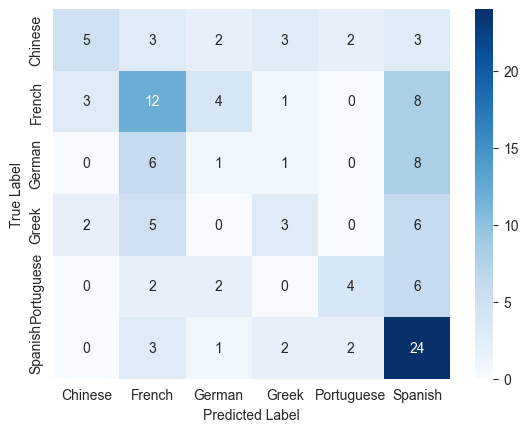

In [208]:
# Plot a confusion matrix

create_cm(y_test_lr, y_hat_lr)

#### Weighted logistic regression for imbalanced dataset

As we see in the report above, the classes we are predicting are not balanced. The high accuracy we see on Spanish specifically could just be due to there being more samples in the training dataset for these two languages. Thus, we should employ downweighting and overweighting techniques to adjust for this, and see what our accuracy is like afterwards. We will actually just weight the classes when computing the loss in the logistic regression by setting the `class_weight` parameter to `"balanced"`.

In [209]:
y_train.shape

(980, 1)

In [210]:
y_train.groupby("native_language").size()

native_language
Chinese        97
French        236
German         95
Greek         110
Portuguese    108
Spanish       334
dtype: int64

In [211]:
weighted_lr_model = LogisticRegression(random_state = 3, multi_class='multinomial', solver='lbfgs', class_weight = "balanced")
weighted_lr_model.fit(X_train_lr, y_train_lr)

/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=3)

In [212]:
y_hat_lr_weighted = weighted_lr_model.predict(X_test_lr)

# Classification report on testing data
print("classification report (testing, weighted):\n", classification_report(y_test_lr, y_hat_lr_weighted))

classification report (testing, weighted):
               precision    recall  f1-score   support

     Chinese       0.45      0.28      0.34        18
      French       0.45      0.54      0.49        28
      German       0.13      0.12      0.13        16
       Greek       0.30      0.19      0.23        16
  Portuguese       0.40      0.29      0.33        14
     Spanish       0.49      0.69      0.57        32

    accuracy                           0.41       124
   macro avg       0.37      0.35      0.35       124
weighted avg       0.40      0.41      0.39       124



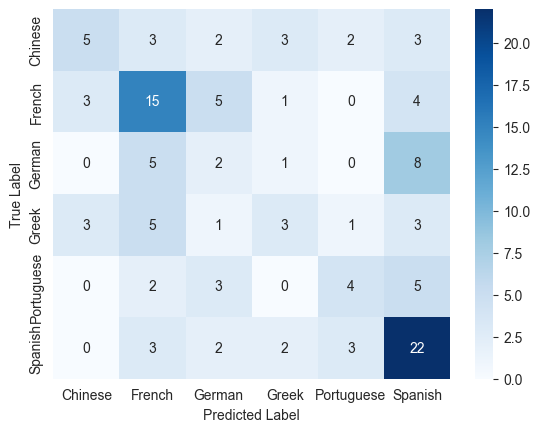

In [213]:
# Visualize confusion matrix for weighted logistic regression

create_cm(y_test_lr, y_hat_lr_weighted)

The accuracy and macro-F1 have slightly improved.

### 3) Logistic regression model (n-grams with CountVectorizer)

To capture more contextual information, we'll slightly modify the code from the previous section to incorporate bi-grams and tri-grams with the `ngram_range` parameter in `CountVectorizer`.

In [214]:
# Test ranges of n-grams

ngrams_list = [(1,2),(2,2),(2,3),(1,3)]

for ngram_i in ngrams_list:
  # Vectorize training data, varying the ngram_range
  vectorizer = CountVectorizer(stop_words = "english", ngram_range = ngram_i)
  X_train_lr_ngram = vectorizer.fit_transform(X_train["answer"])
  X_test_lr_ngram = vectorizer.transform(X_test["answer"])

  # Fit model
  weighted_lr_model_ngram = LogisticRegression(random_state = 3, multi_class='multinomial', solver='lbfgs', class_weight = "balanced")
  weighted_lr_model_ngram.fit(X_train_lr_ngram, y_train_lr)

  y_hat_lr_weighted_ngram = weighted_lr_model_ngram.predict(X_test_lr_ngram)

  # Classification report on testing data
  print("classification report (testing, weighted):\n", f'ngram_range: {ngram_i}\n',
        classification_report(y_test_lr, y_hat_lr_weighted_ngram),"\n")

/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


classification report (testing, weighted):
 ngram_range: (1, 2)
               precision    recall  f1-score   support

     Chinese       0.71      0.28      0.40        18
      French       0.43      0.57      0.49        28
      German       0.12      0.06      0.08        16
       Greek       0.50      0.25      0.33        16
  Portuguese       0.50      0.21      0.30        14
     Spanish       0.43      0.78      0.56        32

    accuracy                           0.44       124
   macro avg       0.45      0.36      0.36       124
weighted avg       0.45      0.44      0.40       124
 



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


classification report (testing, weighted):
 ngram_range: (2, 2)
               precision    recall  f1-score   support

     Chinese       1.00      0.11      0.20        18
      French       0.37      0.46      0.41        28
      German       0.20      0.06      0.10        16
       Greek       0.67      0.25      0.36        16
  Portuguese       1.00      0.07      0.13        14
     Spanish       0.39      0.91      0.54        32

    accuracy                           0.40       124
   macro avg       0.60      0.31      0.29       124
weighted avg       0.55      0.40      0.34       124
 



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learn

classification report (testing, weighted):
 ngram_range: (2, 3)
               precision    recall  f1-score   support

     Chinese       1.00      0.06      0.11        18
      French       0.34      0.39      0.37        28
      German       0.00      0.00      0.00        16
       Greek       0.75      0.19      0.30        16
  Portuguese       0.00      0.00      0.00        14
     Spanish       0.36      0.94      0.52        32

    accuracy                           0.36       124
   macro avg       0.41      0.26      0.21       124
weighted avg       0.41      0.36      0.27       124
 



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


classification report (testing, weighted):
 ngram_range: (1, 3)
               precision    recall  f1-score   support

     Chinese       0.33      0.06      0.10        18
      French       0.38      0.54      0.45        28
      German       0.00      0.00      0.00        16
       Greek       0.50      0.25      0.33        16
  Portuguese       0.50      0.14      0.22        14
     Spanish       0.39      0.78      0.52        32

    accuracy                           0.38       124
   macro avg       0.35      0.29      0.27       124
weighted avg       0.36      0.38      0.32       124
 



It looks like bi-grams were not helpful... :(



### 4) Logistic regression model (POS tags with CountVectorizer)

Goal: see if bi-grams and POS (part-of-speech) tags can help at all. Use `nltk`'s POS tagger. Do include stop words, and set min word count. We wanted to somehow do bi-grams and tri-grams of the POS tags themselves but not sure how this would work...?

Much of the code from this section is from HW 3.

POS tagging method inspired by paper where the Reddit L2 dataset came from (Native language cognate effects on second language lexical choice) - (https://github.com/ellarabi/reddit-l2/blob/master/preprocess_reddit_data.py). For each word, append the corresponding POS tag.

In [215]:
!pip install nltk

In [216]:
import nltk
import scipy

from sklearn.compose import ColumnTransformer

In [217]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/anjieliu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/anjieliu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [218]:
# Transform original text by appending POS tag to end of each word

def append_pos_tags(text):
  text_with_pos = []

  text = nltk.sent_tokenize(text)
  processed_sents = [nltk.word_tokenize(sentence) for sentence in text]

  for sentence in nltk.pos_tag_sents(processed_sents):
    sentence_with_pos = []
    for pair in sentence:
      tagged_word = pair[0] + "_" + pair[1]
      sentence_with_pos.append(tagged_word)
    sentence_with_pos = " ".join(sentence_with_pos)
    text_with_pos.append(sentence_with_pos)

  text_with_pos = "\n".join(text_with_pos)

  return text_with_pos

In [219]:
sample = X_train["answer"][1]

append_pos_tags(sample)

"As_IN our_PRP$ class_NN is_VBZ going_VBG to_TO mark_VB a_DT short_JJ video_NN about_IN daily_JJ life_NN at_IN college_NN ,_, I_PRP write_VBP this_DT report_NN to_TO suggest_VB some_DT lessons_NNS and_CC activities_NNS which_WDT should_MD be_VB filmed_VBN ._.\n1_CD ._.\nEnglish_JJ lesson_NN ._.\nBecause_IN all_DT students_NNS in_IN English_JJ class_NN are_VBP from_IN all_DT over_IN the_DT world_NN ._.\nWe_PRP can_MD talk_VB everybody_NN 's_POS feeling_NN living_NN and_CC study_NN at_IN a_DT foreign_JJ country_NN ._.\n2_CD ._.\nComputing_VBG lesson_NN and_CC computer_NN room_NN ._.\nNowdays_JJ internet_NN makes_VBZ us_PRP closer_JJR and_CC closer_RBR ._.\nWe_PRP can_MD get_VB all_DT what_WP we_PRP want_VBP on_IN internet_NN ._.\nIt_PRP 's_VBZ one_CD of_IN the_DT most_RBS important_JJ things_NNS in_IN our_PRP$ life_NN now_RB ._.\n3_CD ._.\nLiabrary_NNP ._.\nWe_PRP not_RB only_RB borrow_VB books_NNS from_IN liabrary_JJ but_CC also_RB study_VBP at_IN liabrary_JJ ._.\nLibrary_NNP is_VBZ ver

It looks like the writer's speech errors will cause the POS tagger to incorrectly tag some words; for example, library (highlighted below) is misspelled as "liabrary", and was tagged as an adjective (JJ) when it's rather a noun.

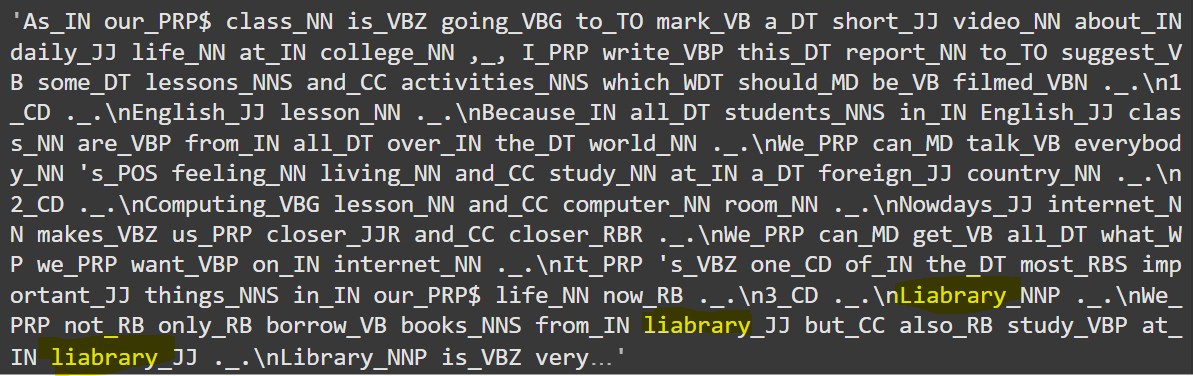

Now let's apply this to the FCE dataset and see what results we'll get from logistic regression then, first just with bag of words:

In [220]:
X_train_tagged = X_train["answer"].apply(append_pos_tags)

In [221]:
X_test_tagged = X_test["answer"].apply(append_pos_tags)

In [222]:
# Vectorize training data
vectorizer_pos = CountVectorizer(stop_words = "english")

X_train_lr_pos = vectorizer_pos.fit_transform(X_train_tagged)
X_test_lr_pos = vectorizer_pos.transform(X_test_tagged)

# Fit model
weighted_lr_model_pos = LogisticRegression(random_state = 3, multi_class='multinomial', solver='lbfgs', class_weight = "balanced")
weighted_lr_model_pos.fit(X_train_lr_pos, y_train_lr)

y_hat_lr_weighted_pos = weighted_lr_model_pos.predict(X_test_lr_pos)

# Classification report on testing data
print("classification report (testing, weighted):\n",
      classification_report(y_test_lr, y_hat_lr_weighted_pos))

/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


classification report (testing, weighted):
               precision    recall  f1-score   support

     Chinese       0.62      0.44      0.52        18
      French       0.54      0.68      0.60        28
      German       0.36      0.31      0.33        16
       Greek       0.60      0.38      0.46        16
  Portuguese       0.33      0.29      0.31        14
     Spanish       0.47      0.59      0.53        32

    accuracy                           0.49       124
   macro avg       0.49      0.45      0.46       124
weighted avg       0.50      0.49      0.48       124



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy has improved a little!

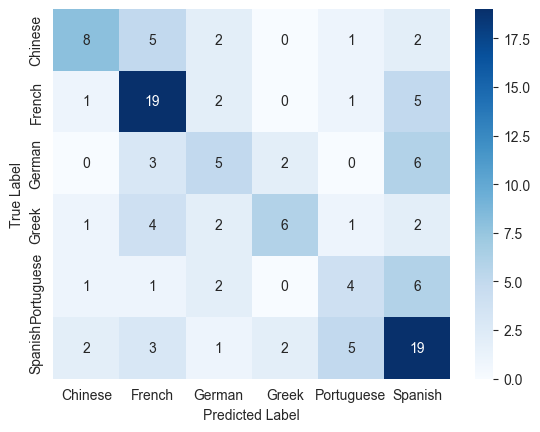

In [223]:
# Visualize confusion matrix for weighted logistic regression + POS tags
create_cm(y_test_lr, y_hat_lr_weighted_pos)

How about bi-grams now?

In [224]:
# Vectorize training data
vectorizer = CountVectorizer(stop_words = "english", ngram_range = (2,2))

X_train_lr_pos = vectorizer.fit_transform(X_train_tagged)
X_test_lr_pos = vectorizer.transform(X_test_tagged)

# Fit model
weighted_lr_model_pos_2 = LogisticRegression(random_state = 3, multi_class='multinomial', solver='lbfgs', class_weight = "balanced")
weighted_lr_model_pos_2.fit(X_train_lr_pos, y_train_lr)

y_hat_lr_weighted_pos = weighted_lr_model_pos_2.predict(X_test_lr_pos)

# Classification report on testing data
print("classification report (testing, weighted):\n",
      classification_report(y_test_lr, y_hat_lr_weighted_pos))

/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


classification report (testing, weighted):
               precision    recall  f1-score   support

     Chinese       0.40      0.22      0.29        18
      French       0.34      0.57      0.43        28
      German       0.60      0.19      0.29        16
       Greek       0.33      0.12      0.18        16
  Portuguese       0.50      0.21      0.30        14
     Spanish       0.38      0.59      0.46        32

    accuracy                           0.38       124
   macro avg       0.43      0.32      0.32       124
weighted avg       0.41      0.38      0.35       124



Okay, still not that good. What if we get rid of all the words and just use the POS tags?

In [225]:
# Transform original text by replacing each word with the corresponding POS tag

def substitute_pos_tags(text):
  text_pos = []

  text = nltk.sent_tokenize(text)
  processed_sents = [nltk.word_tokenize(sentence) for sentence in text]

  for sentence in nltk.pos_tag_sents(processed_sents):
    sentence_pos = []
    for pair in sentence:
      pos = pair[1]
      sentence_pos.append(pos)
    sentence_pos = " ".join(sentence_pos)
    text_pos.append(sentence_pos)

  text_pos = "\n".join(text_pos)

  return text_pos

In [226]:
# Test it really quick

sample = X_train["answer"][1]

substitute_pos_tags(sample)

'IN PRP$ NN VBZ VBG TO VB DT JJ NN IN JJ NN IN NN , PRP VBP DT NN TO VB DT NNS CC NNS WDT MD VB VBN .\nCD .\nJJ NN .\nIN DT NNS IN JJ NN VBP IN DT IN DT NN .\nPRP MD VB NN POS NN NN CC NN IN DT JJ NN .\nCD .\nVBG NN CC NN NN .\nJJ NN VBZ PRP JJR CC RBR .\nPRP MD VB DT WP PRP VBP IN NN .\nPRP VBZ CD IN DT RBS JJ NNS IN PRP$ NN RB .\nCD .\nNNP .\nPRP RB RB VB NNS IN JJ CC RB VBP IN JJ .\nNNP VBZ RB JJ IN PRP$ JJ NN .\nCD .\nNNP .\nNN PRP VBP TO VB VB NN , DT NN PRP VBD NN IN EX CC PRP VBP PRP$ JJ NN .\nCD .\nNN .\nWP VBP PRP VB IN NN .\nVBG CC VBG DT NNS .\nPRP MD RB VB NN .\nDT VBP WP PRP VBP MD VB VBN .\nIN DT IN PRP VBP JJ NN , PRP MD VB RB .\nCC PRP VBP DT CD NN CC NNS VBP RBS JJ IN PRP$ JJ NN IN NN .'

In [227]:
X_train_pos = X_train["answer"].apply(substitute_pos_tags)
X_test_pos = X_test["answer"].apply(substitute_pos_tags)

In [228]:
# Test ranges of n-grams

ngrams_list = [(1,1),(1,2),(2,2),(2,3),(1,3)]

for ngram_i in ngrams_list:
  # Vectorize training data, varying the ngram_range
  vectorizer = CountVectorizer(stop_words = "english", ngram_range = ngram_i)
  X_train_lr_ngram_pos = vectorizer.fit_transform(X_train_pos)
  X_test_lr_ngram_pos = vectorizer.transform(X_test_pos)

  # Fit model
  weighted_lr_model_ngram_pos = LogisticRegression(random_state = 3, multi_class='multinomial', solver='lbfgs', class_weight = "balanced")
  weighted_lr_model_ngram_pos.fit(X_train_lr_ngram_pos, y_train_lr)

  y_hat_lr_weighted_ngram_pos = weighted_lr_model_ngram_pos.predict(X_test_lr_ngram_pos)

  # Classification report on testing data
  print("classification report (testing, weighted):\n", f'ngram_range: {ngram_i}\n',
        classification_report(y_test_lr, y_hat_lr_weighted_ngram_pos),"\n")

classification report (testing, weighted):
 ngram_range: (1, 1)
               precision    recall  f1-score   support

     Chinese       0.23      0.28      0.25        18
      French       0.38      0.21      0.27        28
      German       0.17      0.25      0.21        16
       Greek       0.27      0.38      0.32        16
  Portuguese       0.23      0.36      0.28        14
     Spanish       0.32      0.19      0.24        32

    accuracy                           0.26       124
   macro avg       0.27      0.28      0.26       124
weighted avg       0.28      0.26      0.26       124
 



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

classification report (testing, weighted):
 ngram_range: (1, 2)
               precision    recall  f1-score   support

     Chinese       0.24      0.33      0.28        18
      French       0.25      0.14      0.18        28
      German       0.18      0.19      0.18        16
       Greek       0.26      0.31      0.29        16
  Portuguese       0.29      0.50      0.37        14
     Spanish       0.26      0.19      0.22        32

    accuracy                           0.25       124
   macro avg       0.25      0.28      0.25       124
weighted avg       0.25      0.25      0.24       124
 

classification report (testing, weighted):
 ngram_range: (2, 2)
               precision    recall  f1-score   support

     Chinese       0.20      0.28      0.23        18
      French       0.15      0.14      0.15        28
      German       0.12      0.06      0.08        16
       Greek       0.20      0.19      0.19        16
  Portuguese       0.11      0.14      0.12        14


/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

classification report (testing, weighted):
 ngram_range: (2, 3)
               precision    recall  f1-score   support

     Chinese       0.29      0.28      0.29        18
      French       0.26      0.32      0.29        28
      German       0.15      0.12      0.14        16
       Greek       0.57      0.25      0.35        16
  Portuguese       0.08      0.07      0.07        14
     Spanish       0.28      0.34      0.31        32

    accuracy                           0.26       124
   macro avg       0.27      0.23      0.24       124
weighted avg       0.28      0.26      0.26       124
 



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


classification report (testing, weighted):
 ngram_range: (1, 3)
               precision    recall  f1-score   support

     Chinese       0.25      0.28      0.26        18
      French       0.19      0.25      0.22        28
      German       0.22      0.12      0.16        16
       Greek       0.40      0.25      0.31        16
  Portuguese       0.14      0.14      0.14        14
     Spanish       0.26      0.28      0.27        32

    accuracy                           0.23       124
   macro avg       0.24      0.22      0.23       124
weighted avg       0.24      0.23      0.23       124
 



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Testing on Reddit L2 dataset

That didn't really do anything, unfortunately... so our best model right now is Logistic Regression with CountVectorizer (just unigrams) and appending the POS tag to each word. Let's test that model on the Reddit L2 dataset:

In [229]:
reddit_sample

,comments,native_language
101073,international politics is becoming more like O...,Chinese
286745,translation,German
128155,"right now your question is confusing , you put...",French
583153,i would love DATE fest,Portuguese
362460,i had CARDINAL settlers in my sanctuary using ...,German
...,...,...
229559,only the original one used to put it online was .,French
454156,it has no disadvantages .,Greek
540374,"`` actually , no , that 's not true , here 's ...",Portuguese
68038,you give them ORG and by the time they like it...,Chinese


In [230]:
reddit_tagged = reddit_sample["comments"].apply(append_pos_tags)
reddit_tagged.head()

101073    international_JJ politics_NNS is_VBZ becoming_...
286745                                       translation_NN
128155    right_RB now_RB your_PRP$ question_NN is_VBZ c...
583153              i_NN would_MD love_VB DATE_NNP fest_JJS
362460    i_NN had_VBD CARDINAL_NNP settlers_NNS in_IN m...
Name: comments, dtype: object

In [231]:

X_reddit_tagged = vectorizer_pos.transform(reddit_tagged)

In [232]:
reddit_yhat = weighted_lr_model_pos.predict(X_reddit_tagged)

classification report (reddit, weighted):
               precision    recall  f1-score   support

     Chinese       0.23      0.05      0.08       259
      French       0.17      0.22      0.19       262
      German       0.19      0.06      0.10       233
       Greek       0.19      0.03      0.06       242
  Portuguese       0.17      0.46      0.25       254
     Spanish       0.17      0.20      0.19       250

    accuracy                           0.17      1500
   macro avg       0.19      0.17      0.14      1500
weighted avg       0.19      0.17      0.14      1500
 



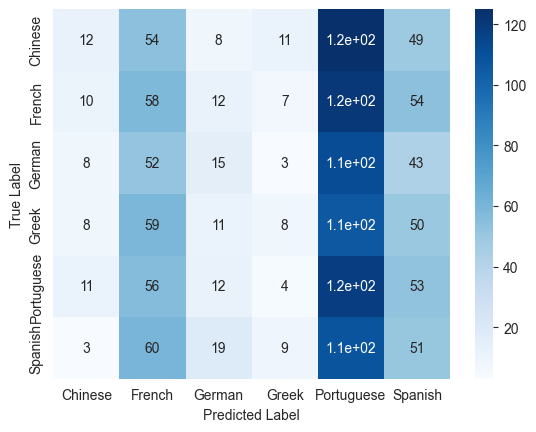

In [233]:
print("classification report (reddit, weighted):\n",
        classification_report(reddit_sample["native_language"], reddit_yhat),"\n")

create_cm(reddit_sample["native_language"], reddit_yhat)

This is predicting most things as French and/or Portuguese, but it's unclear why Portuguese is being so commonly predicted -- there are fewer Portuguese examples in the training set...